In [17]:
from os.path import join
import numpy as np
from scipy import optimize, stats
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Plot prior trajectories

In [26]:
lens = np.array([0.5, 0.5, 1.0])
sigmas = np.array([0.25, 0.5, 0.5, 0.5])

def segment_points(xy, length, angle):
    uv = np.array(xy)[:, :]
    angle = np.array(angle)
    uv[:, 0] += length * np.cos(angle)
    uv[:, 1] += length * np.sin(angle)
    return xy, uv

def kinematics(x):
    starting_pos = np.stack([np.zeros((x.shape[0])), x[:, 0]], axis=1)
    x0, x1 = segment_points(starting_pos, lens[0], x[:,1])
    x1, x2 = segment_points(x1, lens[1], x[:,1] + x[:,2])
    x2, x3 = segment_points(x2, lens[2], x[:,1] + x[:,2] + x[:,3])
    return x3

def generate_data(tot_dataset_size):

    np.random.seed(0)
    x = np.random.normal(size=(tot_dataset_size, 4), scale=sigmas)
    y = kinematics(x)

    return x, y

In [27]:
def kinematic_all(x):
    starting_pos = np.stack([np.zeros((x.shape[0])), x[:, 0]], axis=1)
    x0, x1 = segment_points(starting_pos, lens[0], x[:,1])
    x1, x2 = segment_points(x1, lens[1], x[:,1] + x[:,2])
    x2, x3 = segment_points(x2, lens[2], x[:,1] + x[:,2] + x[:,3])
    return x0, x1, x2, x3

In [30]:
np.random.seed(0)
nTrajs = 1000
x = kinematic_all(np.random.normal(size=(nTrajs, 4), scale=sigmas))

In [31]:
trajs = np.zeros( (2, 4, n_kinematic) )
for i in range(n_kinematic):
    trajs[0,:,i] = np.array([x[0][i,0], x[1][i,0], x[2][i,0], x[3][i,0]])
    trajs[1,:,i] = np.array([x[0][i,1], x[1][i,1], x[2][i,1], x[3][i,1]])

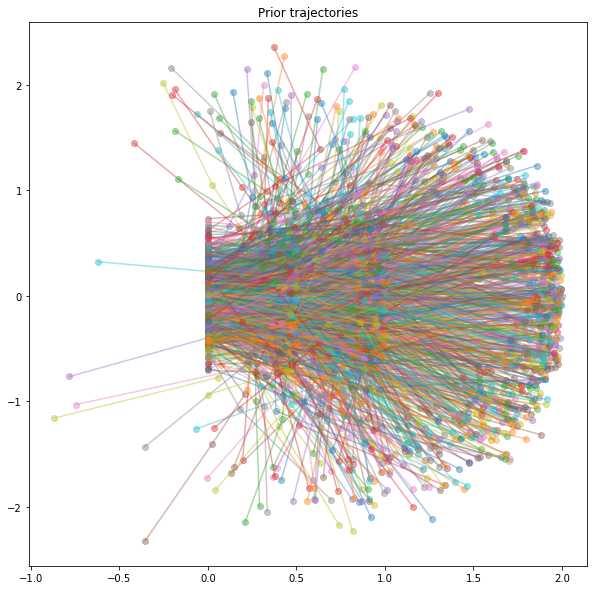

In [32]:
plt.figure(0, figsize = (10,10) )
plt.plot(trajs[0], trajs[1], 'o-', alpha = 0.4);
plt.title('Prior trajectories');

# Kinematic inference model

In [64]:
class KINEMATIC:
    def __init__(self):
        self.DoF = 4
        self.lens = np.array([0.5, 0.5, 1.0])[:,np.newaxis]
        self.sigmas = np.array([0.25, 0.5, 0.5, 0.5])[:,np.newaxis]
        self.sigmas2 = self.sigmas ** 2
        
        self.std = 0.1
        self.var = self.std ** 2
        self.nData = 10
        np.random.seed(0)
        self.thetaTrue = np.random.normal(size = 4, scale = np.ndarray.flatten(self.sigmas))
        self.data_x, self.data_y = self.simulateData()
      
    def getForwardModel(self, thetas):      
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        cumthetas = np.cumsum(thetas[1:,:], 0)
        Fx = np.sum(self.lens * np.cos( cumthetas ), 0)
        Fy = thetas[0,:] + np.sum(self.lens * np.sin( cumthetas ), 0)
        return Fx, Fy
    
    def simulateData(self):
        noise = np.random.normal( scale = self.std, size = (2, self.nData) )
        Fx, Fy = self.getForwardModel(self.thetaTrue)
        return (Fx + noise[0])[:,np.newaxis], (Fy + noise[1])[:,np.newaxis]
        
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        cumthetas = np.cumsum(thetas[1:], 0)
        cumlensin = np.cumsum((self.lens * np.sin(cumthetas))[::-1], 0)[::-1]
        cumlencos = np.cumsum((self.lens * np.cos(cumthetas))[::-1], 0)[::-1]
        Jx = np.vstack( (np.zeros(nSamples), - cumlensin) )
        Jy = np.vstack( (np.ones(nSamples),    cumlencos) )
        return Jx, Jy
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = 0.5 * np.sum(thetas ** 2 / self.sigmas2, 0) 
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        (Fx, Fy) = (arg[0], arg[1]) if len(arg) > 0 else self.getForwardModel(thetas)
        shift_x = Fx - self.data_x
        shift_y = Fy - self.data_y
        tmp = 0.5 * np.sum( shift_x ** 2 + shift_y ** 2, 0 ) / self.var
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = thetas / self.sigmas2
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        (Fx, Fy) = (arg[0], arg[1]) if len(arg) > 0 else self.getForwardModel(thetas)   
        (Jx, Jy) = (arg[2], arg[3]) if len(arg) > 2 else self.getJacobianForwardModel(thetas)
        tmp = ( Jx * np.sum(Fx - self.data_x, 0) + Jy * np.sum(Fy - self.data_y, 0) ) / self.var
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        (Jx, Jy) = (arg[0], arg[1]) if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp =  self.nData * ( Jx.reshape(self.DoF, 1, nSamples) * Jx.reshape(1, self.DoF, nSamples) + \
               Jy.reshape(self.DoF, 1, nSamples) * Jy.reshape(1, self.DoF, nSamples) ) / self.var
        tmp += np.diag(1 / np.ndarray.flatten(self.sigmas2)).reshape(self.DoF, self.DoF, 1)
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [87]:
class SVN:
    def __init__(self, model, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = 1000
        self.nIterations = 10
        self.stepsize = 1
        self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )
        if len(arg) == 0:
            self.resetParticles()
        else:
            self.particles = arg[0]
        
    def apply(self):
        maxmaxshiftold = np.inf
        maxshift = np.zeros(self.nParticles)
        Q = np.zeros( (self.DoF, self.nParticles) )
        for iter_ in range(self.nIterations):
            Fx, Fy = self.model.getForwardModel(self.particles)
            Jx, Jy = self.model.getJacobianForwardModel(self.particles)
            gmlpt  = self.model.getGradientMinusLogPosterior(self.particles, Fx, Fy, Jx, Jy)
            Hmlpt  = self.model.getGNHessianMinusLogPosterior(self.particles, Jx, Jy)
            M = np.mean(Hmlpt, 2)
            
            for i_ in range(self.nParticles):
                sign_diff = self.particles[:,i_,np.newaxis] - self.particles
                Msd   = np.matmul(M, sign_diff)
                kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
                gkern = Msd * kern
                
                mgJ = np.mean(- gmlpt * kern + gkern, 1)
                HJ  = np.mean(Hmlpt * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles
                Q[:,i_] = np.linalg.solve(HJ, mgJ)
                maxshift[i_] = np.linalg.norm(Q, np.inf)
            self.particles += self.stepsize * Q         
            maxmaxshift = np.max(maxshift)
#             if iter_ % 10 == 0: print(maxmaxshift) 
            
            if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
                print('Reset particles...')
                self.resetParticles()
                self.stepsize = 1
            elif maxmaxshift < maxmaxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxmaxshiftold = maxmaxshift
                          
    def resetParticles(self):
        self.particles = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis] \
                            + np.random.normal( scale = 0.01, size = (self.DoF, self.nParticles) )

            

In [95]:
model = KINEMATIC()

In [96]:
svn = SVN(model)

In [97]:
svn.apply()

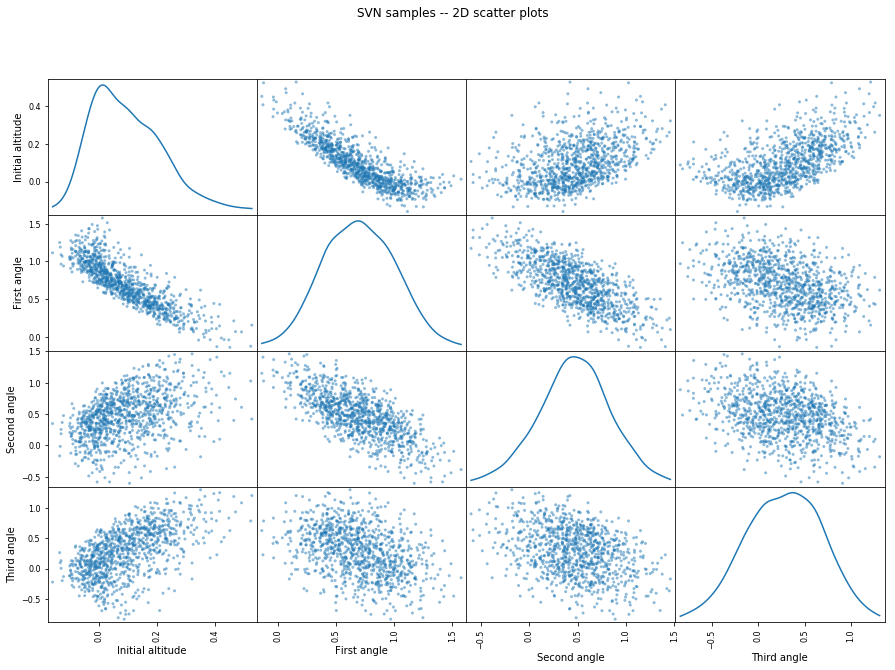

In [98]:
df = pd.DataFrame(svn.particles.T, columns = \
                 ['Initial altitude', 'First angle', 'Second angle', 'Third angle'])
spm = pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(15, 10), diagonal='kde')
plt.suptitle('SVN samples -- 2D scatter plots')
plt.show()

# Plot posterior trajectories

In [99]:
nTrajs = 1000
x = kinematic_all(svn.particles.T)

In [100]:
trajs = np.zeros( (2, 4, nTrajs) )
for i in range(nTrajs):
    trajs[0,:,i] = np.array([x[0][i,0], x[1][i,0], x[2][i,0], x[3][i,0]])
    trajs[1,:,i] = np.array([x[0][i,1], x[1][i,1], x[2][i,1], x[3][i,1]])

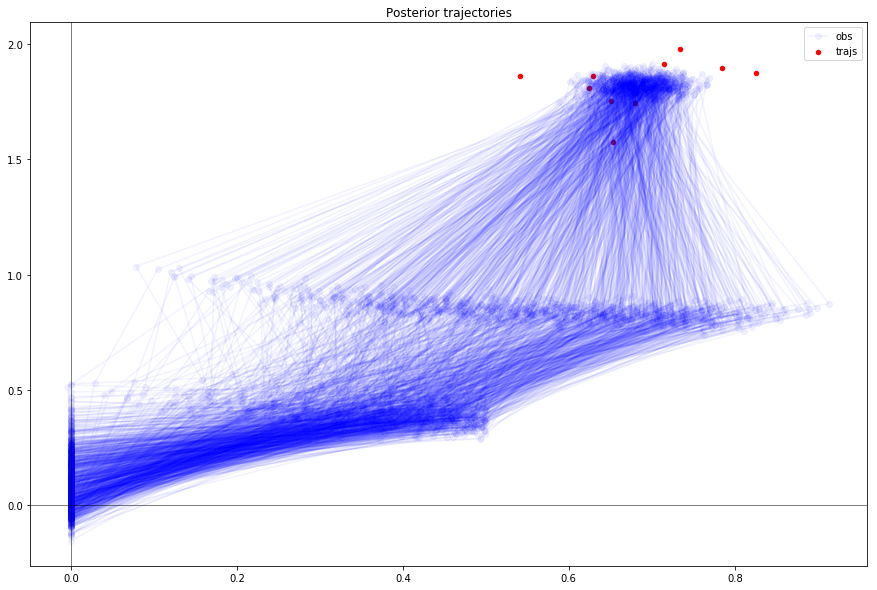

In [101]:
plt.figure(0, figsize = (15,10) )
ax = plt.subplot(1,1,1)
plt.title('Posterior trajectories');
ax1 = plt.plot(trajs[0], trajs[1], 'bo-', alpha = 0.05, label = 'obs');
ax2 = plt.scatter(model.data_x, model.data_y, color = 'r', s = 20, label = 'trajs');
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles[-2:], labels[-2:]);
plt.axhline(linewidth=0.5, color='k');
plt.axvline(linewidth=0.5, color='k');